In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

In [2]:
# Reduce the dataframe just to some categories
filtered_chunks = []
for chunk in pd.read_csv('fiscalia.csv', chunksize=10000):
    filtered_chunk = chunk[chunk['categoria_delito'].isin([
    'HOMICIDIO DOLOSO',
    'LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO',
    'FEMINICIDIO'
    ])]
    filtered_chunks.append(filtered_chunk)
    

In [3]:
df = pd.concat(filtered_chunks, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21632 entries, 0 to 21631
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   anio_inicio           21632 non-null  int64  
 1   mes_inicio            21632 non-null  object 
 2   fecha_inicio          21630 non-null  object 
 3   hora_inicio           21630 non-null  object 
 4   anio_hecho            21623 non-null  float64
 5   mes_hecho             21623 non-null  object 
 6   fecha_hecho           21623 non-null  object 
 7   hora_hecho            21622 non-null  object 
 8   delito                21632 non-null  object 
 9   categoria_delito      21632 non-null  object 
 10  competencia           7121 non-null   object 
 11  fiscalia              21631 non-null  object 
 12  agencia               21632 non-null  object 
 13  unidad_investigacion  21631 non-null  object 
 14  colonia_hecho         14173 non-null  object 
 15  colonia_catalogo   

In [4]:
# remove none rows
df = df.dropna()

In [5]:
# Step 2: Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['fecha_inicio'])

# Step 3: Extract year and month from 'date'
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Step 4: Create geometry column from longitude and latitude
df['geometry'] = df.apply(lambda row: Point(row['longitud'], row['latitud']), axis=1)

# Step 5: Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Step 6: Set coordinate reference system to WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Optional: Read Mexico City shapefile for map overlay (if available)
city_map = gpd.read_file('poligonos_alcaldias_cdmx')

In [6]:
gdf = gpd.clip(gdf, city_map)
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4837 entries, 15076 to 15265
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   anio_inicio           4837 non-null   int64         
 1   mes_inicio            4837 non-null   object        
 2   fecha_inicio          4837 non-null   object        
 3   hora_inicio           4837 non-null   object        
 4   anio_hecho            4837 non-null   float64       
 5   mes_hecho             4837 non-null   object        
 6   fecha_hecho           4837 non-null   object        
 7   hora_hecho            4837 non-null   object        
 8   delito                4837 non-null   object        
 9   categoria_delito      4837 non-null   object        
 10  competencia           4837 non-null   object        
 11  fiscalia              4837 non-null   object        
 12  agencia               4837 non-null   object        
 13  unidad_inv

In [7]:
start_date = pd.to_datetime('2020-09-01')
end_date = pd.to_datetime('2024-11-01')
gdf = gdf[(gdf['date'] >= start_date) & (gdf['date'] < end_date)]
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4832 entries, 15076 to 15265
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   anio_inicio           4832 non-null   int64         
 1   mes_inicio            4832 non-null   object        
 2   fecha_inicio          4832 non-null   object        
 3   hora_inicio           4832 non-null   object        
 4   anio_hecho            4832 non-null   float64       
 5   mes_hecho             4832 non-null   object        
 6   fecha_hecho           4832 non-null   object        
 7   hora_hecho            4832 non-null   object        
 8   delito                4832 non-null   object        
 9   categoria_delito      4832 non-null   object        
 10  competencia           4832 non-null   object        
 11  fiscalia              4832 non-null   object        
 12  agencia               4832 non-null   object        
 13  unidad_inv

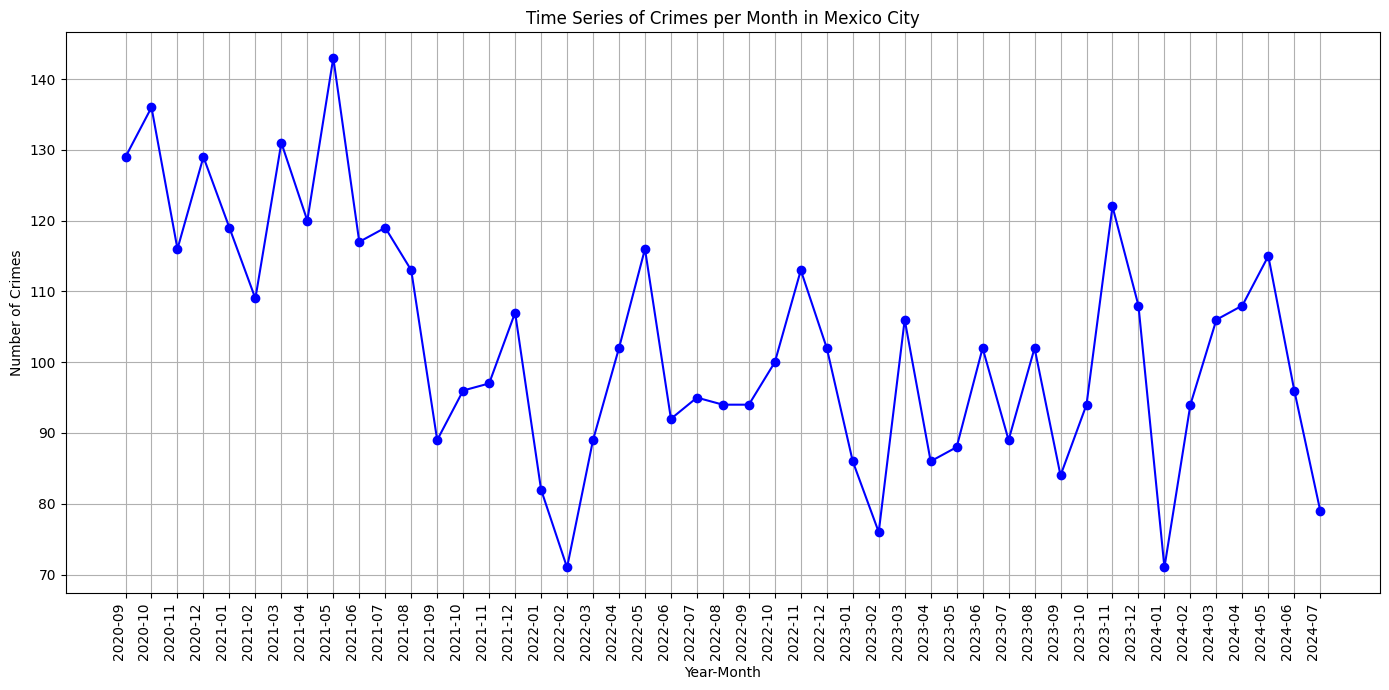

In [8]:
def plot_time_series_crimes_per_month(gdf):
    # Group data by year and month, then count the number of crimes
    gdf['year_month'] = gdf['date'].dt.to_period('M')  # Create a year-month period column
    crime_counts_per_month = gdf.groupby('year_month').size().reset_index(name='crime_count')
    crime_counts_per_month['year_month'] = crime_counts_per_month['year_month'].astype(str)  # Convert to string for plotting

    # Plot the time series
    plt.figure(figsize=(14, 7))
    plt.plot(crime_counts_per_month['year_month'], crime_counts_per_month['crime_count'], marker='o', linestyle='-', color='blue')
    plt.title('Time Series of Crimes per Month in Mexico City')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Crimes')
    plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

# Example usage:
plot_time_series_crimes_per_month(gdf)

/tmp/ipykernel_285950/3420991960.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  crime_counts_per_month['crime_count'].interpolate(method='linear', inplace=True)


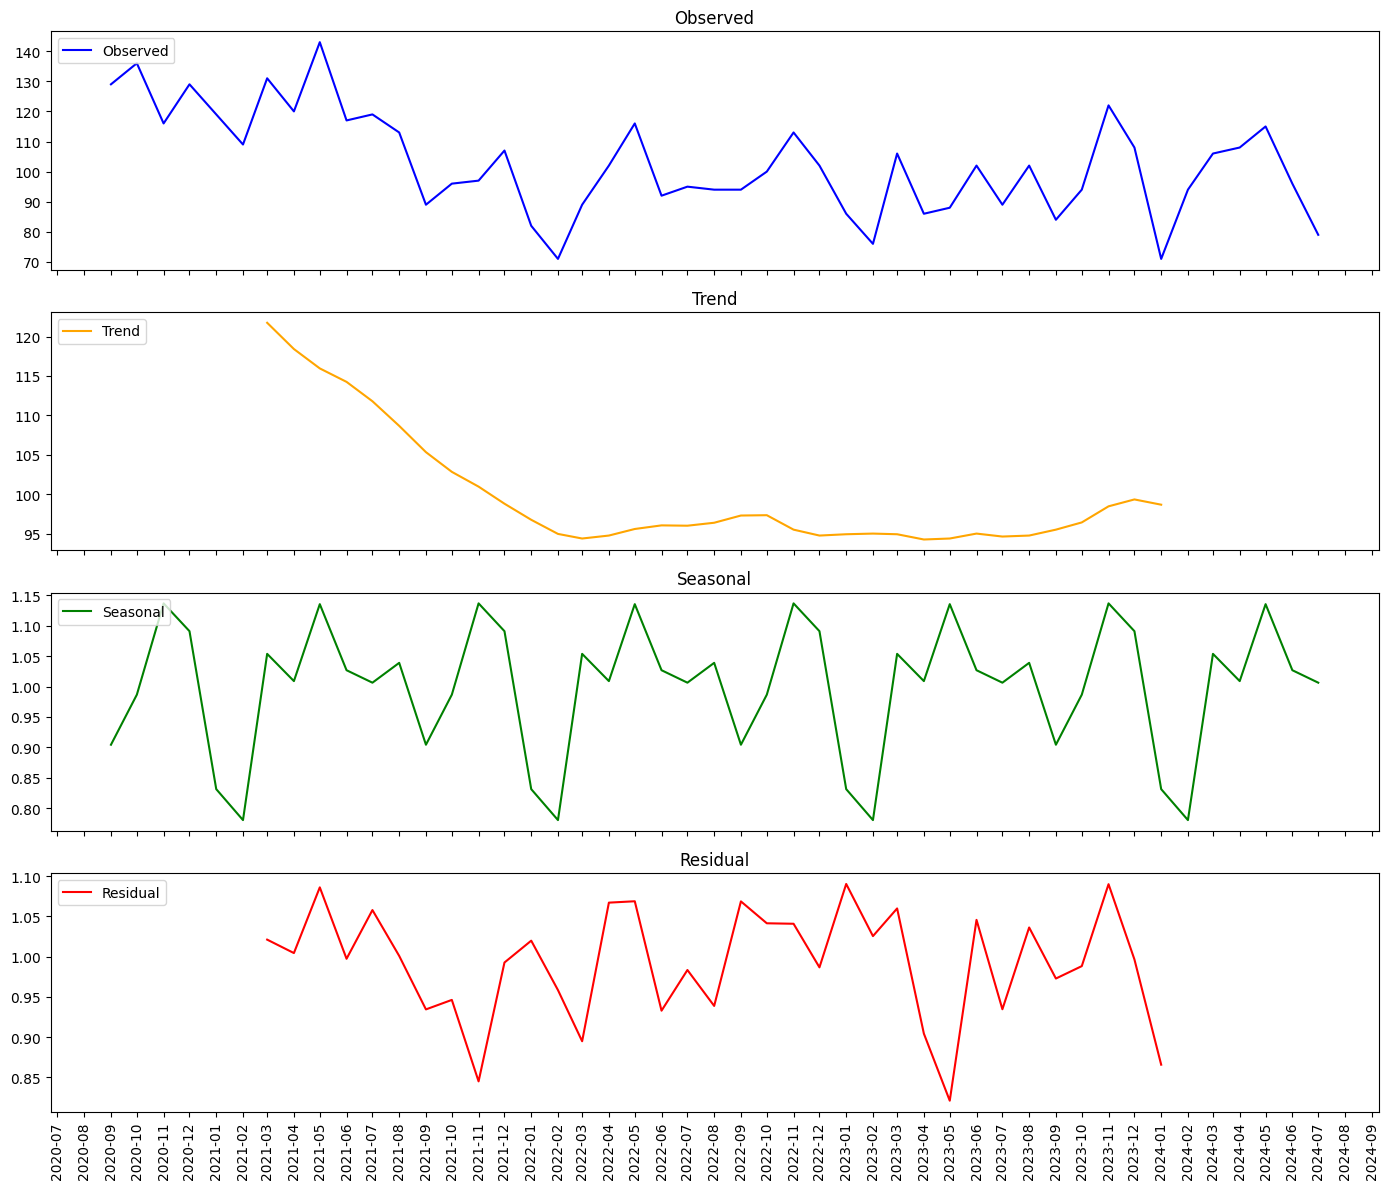

In [9]:
def analyze_time_series_crimes_per_month(gdf):
    # **Filter data to include dates from June 2019 onwards**
    start_date = pd.to_datetime('2019-06-01')
    end_date = pd.to_datetime('2024-11-01')
    gdf_filtered = gdf[(gdf['date'] >= start_date) & (gdf['date'] < end_date)]
   

    # Group data by year and month, then count the number of crimes
    gdf_filtered['year_month'] = gdf_filtered['date'].dt.to_period('M')  # Create a year-month period column
    crime_counts_per_month = gdf_filtered.groupby('year_month').size().reset_index(name='crime_count')

    # Set 'year_month' as the index
    crime_counts_per_month.set_index('year_month', inplace=True)

    # Ensure the index has a frequency
    crime_counts_per_month.index = crime_counts_per_month.index.to_timestamp()
    crime_counts_per_month = crime_counts_per_month.asfreq('MS')  # 'MS' stands for Month Start

    # Handle missing data by interpolating
    crime_counts_per_month['crime_count'].interpolate(method='linear', inplace=True)

    # Perform seasonal decomposition
    result = seasonal_decompose(crime_counts_per_month['crime_count'], model='multiplicative')

    # Extract the components
    observed = result.observed
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid

    # Create a figure with four subplots
    fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

    # Plot observed data
    axs[0].plot(crime_counts_per_month.index, observed, label='Observed', color='blue')
    axs[0].set_title('Observed')
    axs[0].legend(loc='upper left')

    # Plot trend component
    axs[1].plot(crime_counts_per_month.index, trend, label='Trend', color='orange')
    axs[1].set_title('Trend')
    axs[1].legend(loc='upper left')

    # Plot seasonal component
    axs[2].plot(crime_counts_per_month.index, seasonal, label='Seasonal', color='green')
    axs[2].set_title('Seasonal')
    axs[2].legend(loc='upper left')

    # Plot residuals
    axs[3].plot(crime_counts_per_month.index, residual, label='Residual', color='red')
    axs[3].set_title('Residual')
    axs[3].legend(loc='upper left')

    # Format the x-axis to show months
    locator = mdates.MonthLocator(interval=1)  # Adjust interval if needed
    formatter = mdates.DateFormatter('%Y-%m')

    for ax in axs:
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

    # Optionally return the decomposition result
    return result

# Example usage:
result = analyze_time_series_crimes_per_month(gdf)

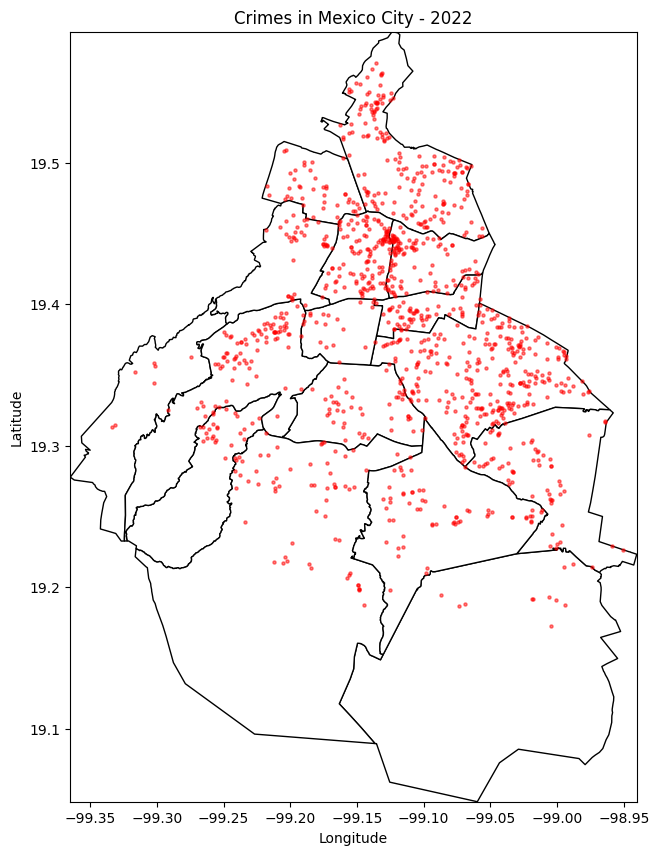

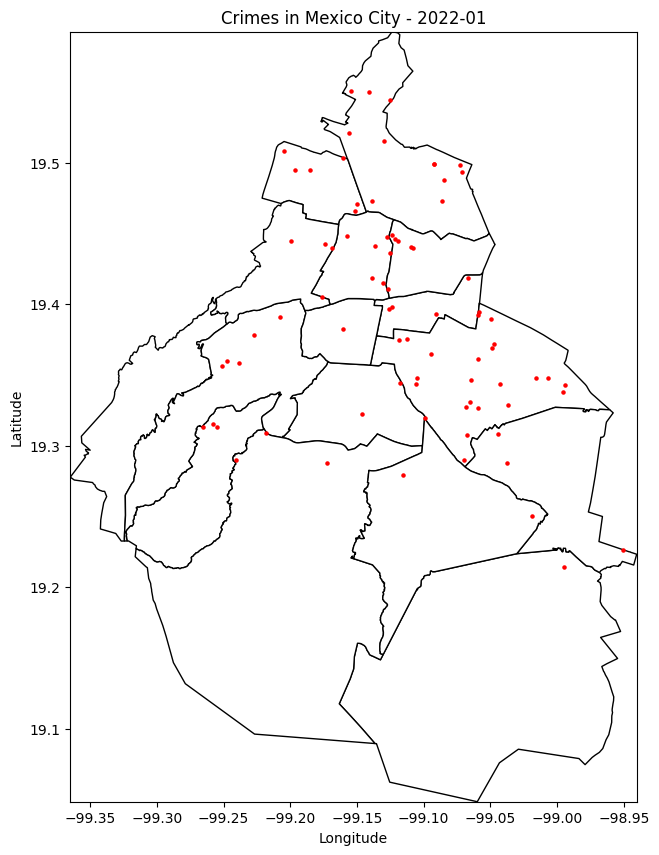

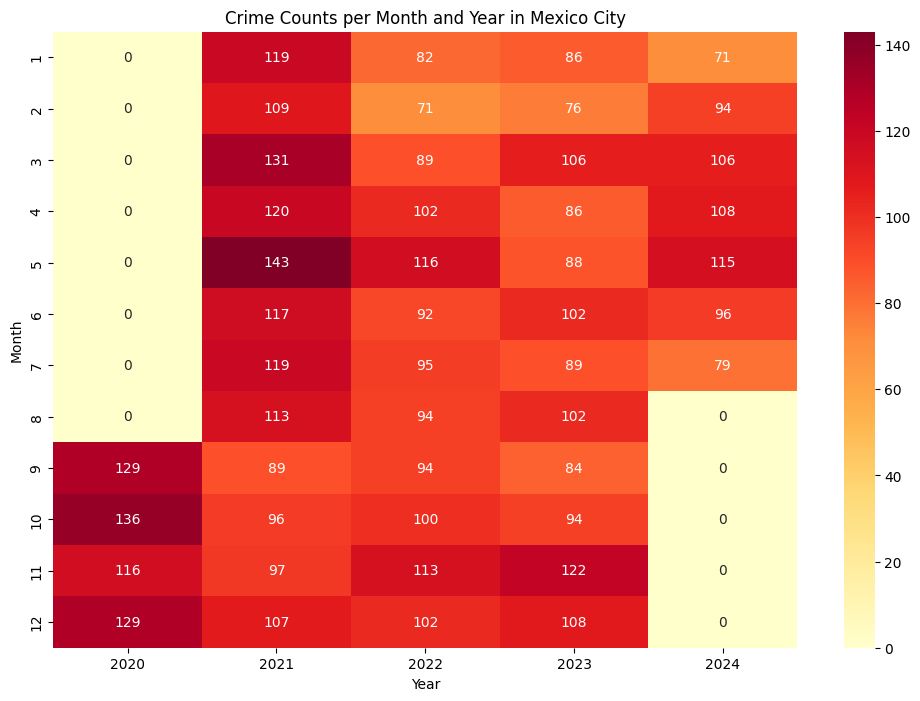

In [10]:
# Function to plot crimes per year
def plot_crimes_by_year(gdf, year):
    # Filter data for the specified year
    gdf_filtered = gdf[gdf['year'] == year]

    if gdf_filtered.empty:
        print(f"No crime data available for {year}.")
        return

    # Ensure both GeoDataFrames are in the same CRS
    if gdf_filtered.crs != city_map.crs:
        gdf_filtered = gdf_filtered.to_crs(city_map.crs)

    # Clip the crime data to the city map extent
    gdf_clipped = gpd.clip(gdf_filtered, city_map)

    if gdf_clipped.empty:
        print(f"No crime data within the city boundaries for {year}.")
        return

    # Plot the city map and crime locations
    fig, ax = plt.subplots(figsize=(10, 10))
    city_map.plot(ax=ax, color='white', edgecolor='black')
    gdf_clipped.plot(ax=ax, marker='o', color='red', markersize=5, alpha=0.5)

    # Set the axis limits to match the city map
    ax.set_xlim(city_map.total_bounds[[0, 2]])
    ax.set_ylim(city_map.total_bounds[[1, 3]])

    plt.title(f'Crimes in Mexico City - {year}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Function to plot crimes per month and year
def plot_crimes_by_month_year(gdf, year, month):
    # Filter data for the specified year and month
    gdf_filtered = gdf[(gdf['year'] == year) & (gdf['month'] == month)]

    if gdf_filtered.empty:
        print(f"No crime data available for {year}-{month:02d}.")
        return

    # Ensure both GeoDataFrames are in the same CRS
    if gdf_filtered.crs != city_map.crs:
        gdf_filtered = gdf_filtered.to_crs(city_map.crs)

    # Clip the crime data to the city map extent
    gdf_clipped = gpd.clip(gdf_filtered, city_map)

    if gdf_clipped.empty:
        print(f"No crime data within the city boundaries for {year}-{month:02d}.")
        return

    # Plot the city map and crime locations
    fig, ax = plt.subplots(figsize=(10, 10))
    city_map.plot(ax=ax, color='white', edgecolor='black')
    gdf_clipped.plot(ax=ax, marker='o', color='red', markersize=5)

    # Set the axis limits to match the city map
    ax.set_xlim(city_map.total_bounds[[0, 2]])
    ax.set_ylim(city_map.total_bounds[[1, 3]])

    plt.title(f'Crimes in Mexico City - {year}-{month:02d}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Function to create a heatmap of crime counts per month and year
def plot_crime_heatmap(gdf):
    crime_counts = gdf.groupby(['year', 'month']).size().reset_index(name='counts')
    crime_counts_pivot = crime_counts.pivot(index='month', columns='year', values='counts')

    # Convert the values in crime_counts_pivot to integers, filling NaNs with 0
    crime_counts_pivot = crime_counts_pivot.fillna(0).astype(int)

    plt.figure(figsize=(12, 8))
    sns.heatmap(crime_counts_pivot, annot=True, fmt="d", cmap="YlOrRd")
    plt.title('Crime Counts per Month and Year in Mexico City')
    plt.ylabel('Month')
    plt.xlabel('Year')
    plt.show()

# Example usage:
# Plot crimes for the year 2022
plot_crimes_by_year(gdf, 2022)

# Plot crimes for January 2022
plot_crimes_by_month_year(gdf, 2022, 1)

# Plot heatmap of crime counts
plot_crime_heatmap(gdf)